In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import mne
import warnings


from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [2]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [3]:
N_S = 2
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

X2,Y2 = Extract_data_from_subject(root_dir,N_S,datatype)

In [4]:
Subj_2 = Select_time_window(X = X2, t_start = Tstart, t_end = Tend, fs = fs)

In [5]:
Subj_2_inner, Labels_2_inner = Transform_for_classificator(X = Subj_2, Y = Y2, Classes = [['ALL']], Conditions = [['Inner']])

In [6]:
input_shape = (Subj_2_inner.shape[1],Subj_2_inner.shape[2],1)
print(input_shape)



(128, 512, 1)


In [7]:
Labels_2_inner[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = Labels_2_inner[:,1]
y = pd.get_dummies(labels)


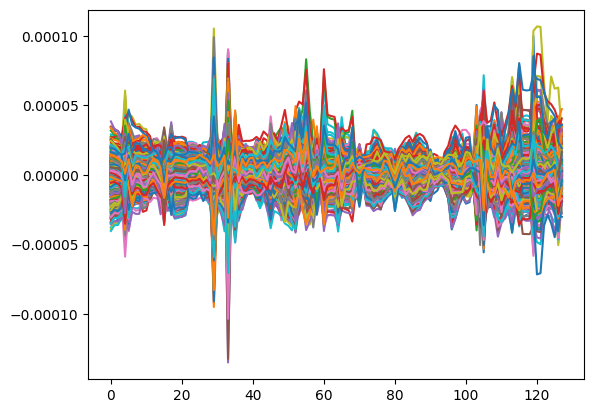

In [8]:
plt.plot(Subj_2_inner[1,:,:]);

## 2. Implement CNN

In [9]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(Subj_2_inner, y, test_size=0.2)


In [10]:
def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(32, kernel_size = (1,7), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,2)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
    model.add(layers.Conv2D(32, kernel_size = (1,7), padding = 'valid', activation='relu'))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(3000, activation='relu'))
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = 'adam', # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

cnn = create_cnn(input_shape)

cnn.summary()                   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 253, 32)      256       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 120, 32)      7200      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 60, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 122880)            0         
                                                                 
 dense (Dense)               (None, 3000)              3

In [11]:
# Train model
history = cnn.fit(
    X_train,
    y_train,
    epochs=2, 
    batch_size=16, # default
    verbose= True  # display progress bar with the training loss and metrics
)

Epoch 1/2
12/12 [==============================] - 70s 6s/step - loss: 1.3955 - accuracy: 0.2292
Epoch 2/2
12/12 [==============================] - 66s 5s/step - loss: 1.3867 - accuracy: 0.2760


In [12]:
# evaluate model
score = cnn.evaluate(
    X_test,
    y_test,
    batch_size = 32,
    verbose =1
)

2/2 [==============================] - 1s 397ms/step - loss: 1.3882 - accuracy: 0.2292
